In [ ]:
!pip install lightning > /dev/null
!pip install torchinfo > /dev/null
!pip install -U segmentation-models-pytorch > /dev/null

In [ ]:
import os, glob, random, shutil, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchinfo import summary

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data visualization

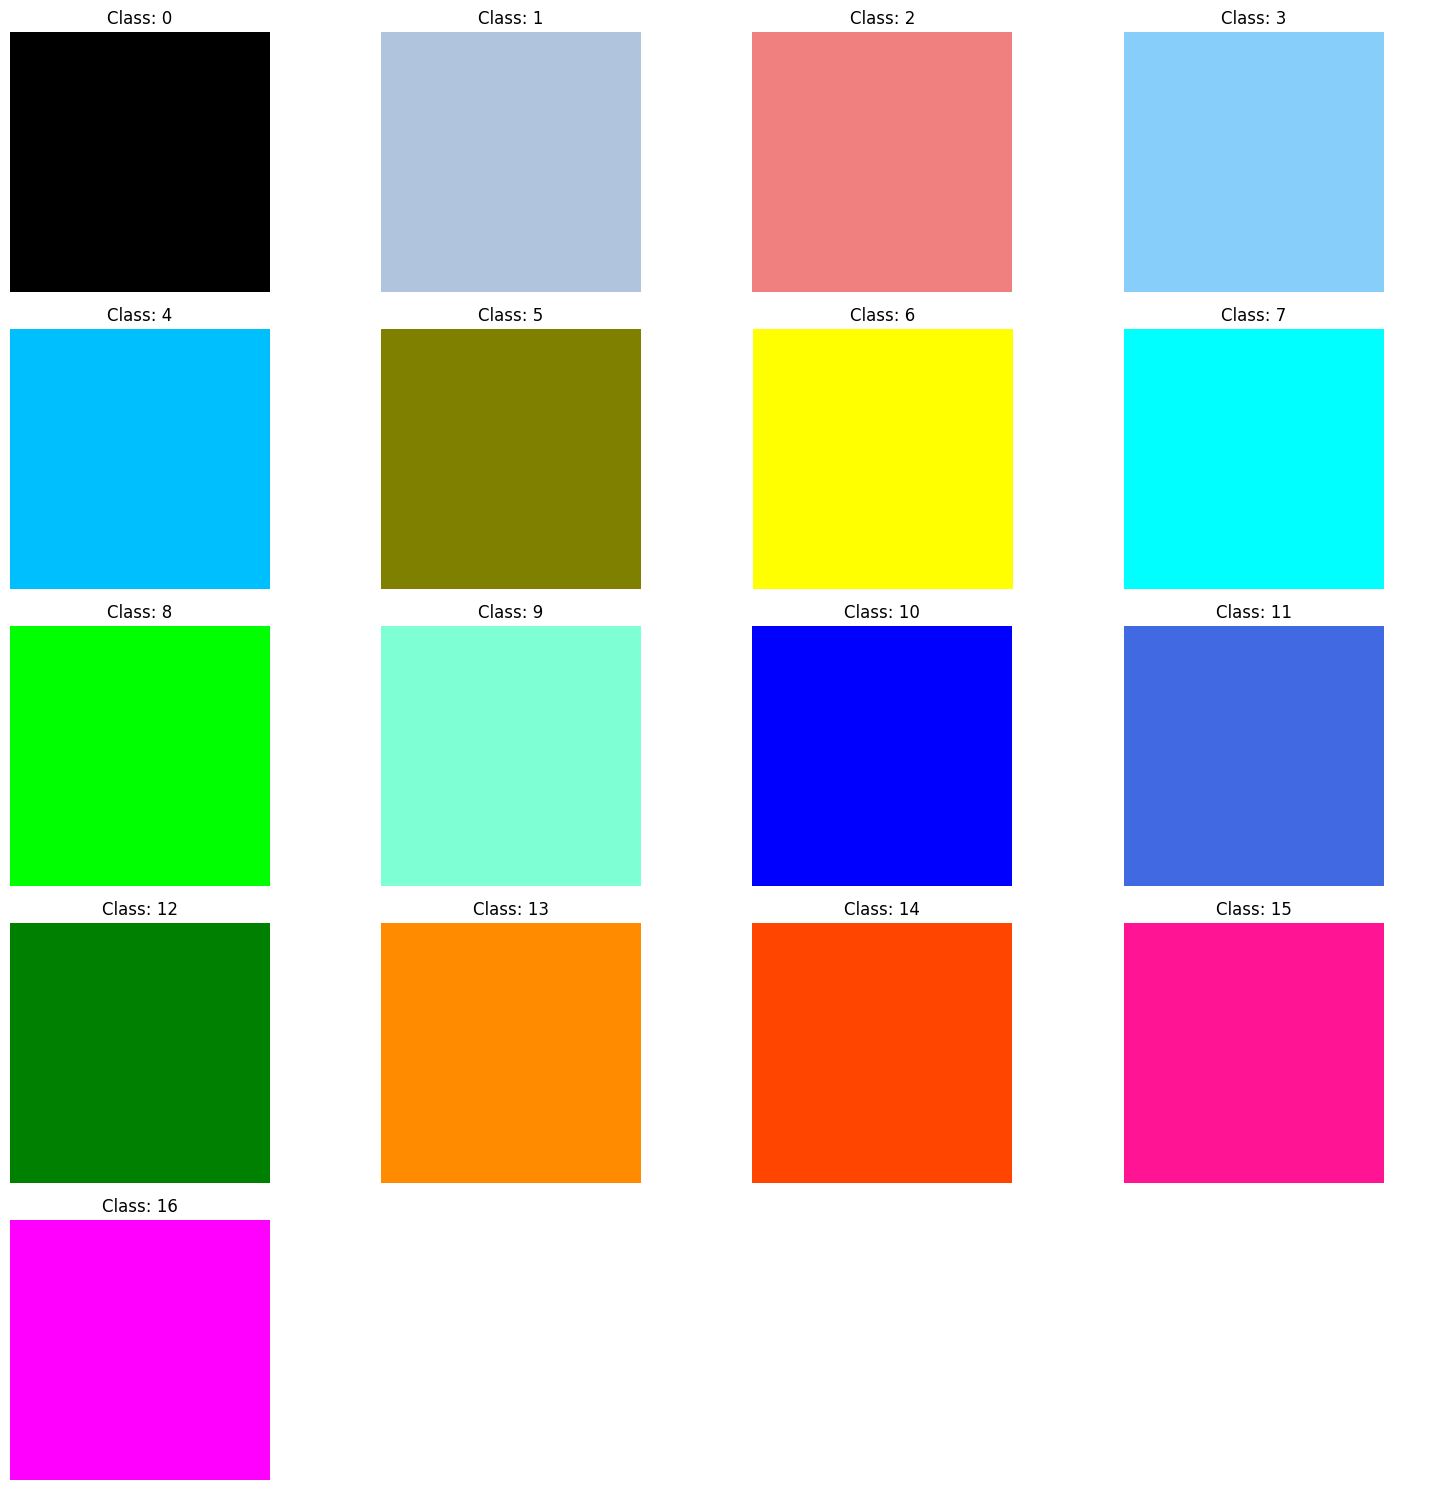

In [ ]:
classdict_path = '/content/drive/MyDrive/VisionChallenge/collaboration_it_mx/collaboration_it_mx/output_images/calss_names_colors.csv'

def load_classdict(path=classdict_path):
    classdict = pd.read_csv(path)
    rgb_to_class = {
        (row['r'], row['g'], row['b']): idx
        for idx, row in classdict.iterrows()
    }
    return rgb_to_class

rgb_to_class = load_classdict(classdict_path)

num_classes = len(rgb_to_class)
num_cols = 4
num_rows = (num_classes + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

for i, (rgb, cls) in enumerate(rgb_to_class.items()):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]  # Get the current subplot

    ax.imshow(np.full((10, 10, 3), rgb, dtype=np.uint8))
    ax.set_title(f"Class: {cls}")
    ax.axis('off')  # Turn off axis ticks and labels

for i in range(num_classes, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off') # Hide subplots not used

plt.tight_layout()
plt.show()

In [ ]:
class StructuralDamageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, classdict_path=None, transform=None, target_transform=None, lazy_class_mapping=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.classdict_path = classdict_path
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform = transform
        self.target_transform = target_transform
        self.lazy_class_mapping = lazy_class_mapping  # Option to defer class mapping

        if len(self.images) != len(self.masks):
            raise ValueError("Number of images and masks must be equal!")

        if not lazy_class_mapping:
            # Process all masks to build class mapping
            self._build_class_mapping()
        else:
            self.unique_values = None  # Will be lazily built

    def _build_class_mapping(self):
        # Efficiently compute unique values across the dataset
        all_values = set()
        for mask_file in self.masks:
            mask_path = os.path.join(self.mask_dir, mask_file)
            mask = np.array(Image.open(mask_path).convert('L'))
            all_values.update(np.unique(mask))

        self.unique_values = sorted(all_values)  # Ensure consistent ordering
        self.value_to_class = {v: i for i, v in enumerate(self.unique_values)}
        self.num_classes = len(self.unique_values)

    def __len__(self):
        return len(self.images)

    def _lazy_class_mapping(self):
        if self.unique_values is None:
            self._build_class_mapping()

    def __getitem__(self, idx):
        try:
            # Build the class mapping lazily if needed
            if self.lazy_class_mapping:
                self._lazy_class_mapping()

            # Get paths
            img_path = os.path.join(self.image_dir, self.images[idx])
            mask_path = os.path.join(self.mask_dir, self.masks[idx])

            # Load the image and mask
            image = Image.open(img_path).convert('RGB')  # RGB image
            mask = Image.open(mask_path).convert('L')    # Grayscale mask (class indices)

            # Resize mask
            mask = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)(mask)
            mask_np = np.array(mask, dtype=np.int64)

            # Remap mask values to class indices
            mask_mapped = np.vectorize(self.value_to_class.get)(mask_np)

            # Convert to one-hot encoding
            mask_onehot = np.zeros((self.num_classes, mask_np.shape[0], mask_np.shape[1]), dtype=np.float32)
            for class_idx in range(self.num_classes):
                mask_onehot[class_idx][mask_mapped == class_idx] = 1.0

            # Convert mask to tensor
            mask_tensor = torch.tensor(mask_mapped, dtype=torch.long)

            # Apply transformations
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)

            if self.target_transform:
                mask_tensor = self.target_transform(mask_tensor)

            return image, mask_tensor
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            raise e

In [ ]:
from sklearn.model_selection import train_test_split

train_path = '/content/drive/MyDrive/VisionChallenge/Attachments/Attachments'
image_dir = os.path.join(train_path, 'image_png')
mask_dir = os.path.join(train_path, 'mask_png')

image_filenames = os.listdir(image_dir)
mask_filenames = os.listdir(mask_dir)

# Split data: 70% train, 15% validation, 15% test
train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.3, random_state=42
)

valid_images, test_images, valid_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)

# Check split lengths
print(f"Train: {len(train_images)}, Validation: {len(valid_images)}, Test: {len(test_images)}")

Train: 2340, Validation: 502, Test: 502


In [ ]:
# Set datasets with lens
train_dataset = StructuralDamageDataset(image_dir, mask_dir, classdict_path, transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
]))
valid_dataset = StructuralDamageDataset(image_dir, mask_dir, classdict_path, transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
]))
test_dataset = StructuralDamageDataset(image_dir, mask_dir, classdict_path, transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
]))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, persistent_workers=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, persistent_workers=True)

In [ ]:
train_batch = next(iter(train_dataloader))

(256, 256, 3)
(256, 256)


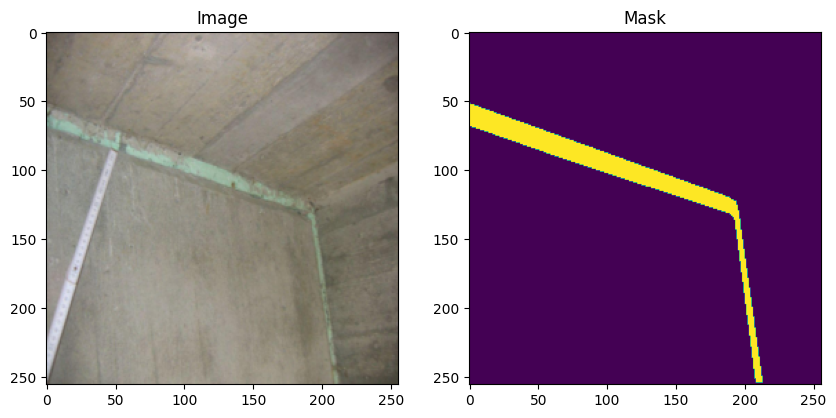

In [26]:
image = train_batch[0][1].permute(1, 2, 0).numpy()
mask = train_batch[1][1].type(torch.int64).numpy()

print(image.shape)
print(mask.shape)

# plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Mask')
plt.show()

In [ ]:
# Load the class-to-color map
classdict = pd.read_csv(classdict_path)
color_map = {row['name']: [row['r'], row['g'], row['b']] for _, row in classdict.iterrows()}  # Map class names to RGB colors

#print("Loaded color map: ", color_map)

# Create a mapping from class names to indices
class_to_index = {class_name: index for index, class_name in enumerate(color_map.keys())}

#print("Class to index mapping: ", class_to_index)


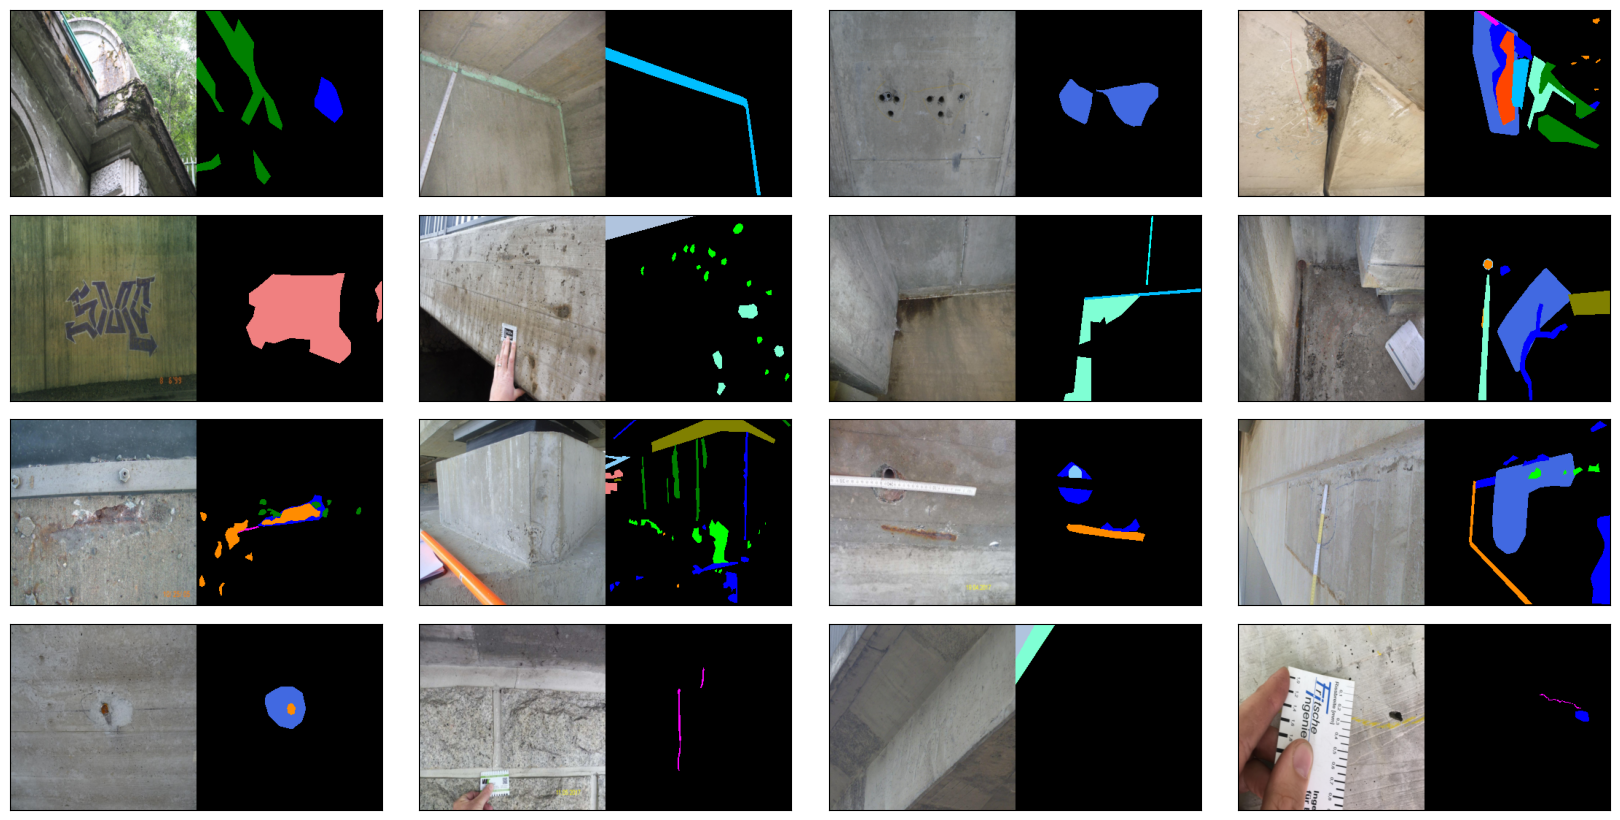

In [28]:
# Create a 4x4 subplot figure for 16 images/masks
fig, ax = plt.subplots(4, 4, figsize=(20, 10))
fig.tight_layout(pad=0.)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)

# Iterate over the first 16 images/masks in the batch
for idx in range(16):
    # Calculate the row and column index for the subplot
    row = idx // 4
    col = idx % 4

    # Extract the image and mask
    image = train_batch[0][idx].permute(1, 2, 0).numpy()  # (H, W, C)
    mask = train_batch[1][idx].numpy()  # (H, W)

    # Ensure both image and mask have the same spatial dimensions
    image = (image * 255).astype("uint8")
    mask_resized = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

    # Create a combined image-mask visualization side by side
    image_mask = np.zeros((256, 512, 3), dtype=np.uint8)  # (H, W*2, C)
    image_mask[:, :256, :] = image  # Add the image on the left
    colored_mask = np.zeros_like(image_mask[:, 256:, :])
    for class_index, color in color_map.items():
        colored_mask[mask_resized == class_to_index[class_index]] = color
    image_mask[:, 256:, :] = colored_mask # Add the colorized mask on the right


    # Display the combined image in the subplot
    ax[row, col].imshow(image_mask)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

plt.show()

### Model

In [ ]:
class StructuralDamageModel(L.LightningModule):
   def __init__(self, arch, encoder_name, in_channels, out_classes):
       super().__init__()

       # Initialize the segmentation model
       self.model = smp.create_model(arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, encoder_weights=None)

       # Store losses
       self.losses = {
           'valid': [],
           'train': [],
           'test': []
       }

       # Preprocessing parameters
       params = smp.encoders.get_preprocessing_params(encoder_name)
       self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
       self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

       # CrossEntropyLoss for multiclass segmentation
       self.loss_fn = torch.nn.CrossEntropyLoss()

   def forward(self, image):
       # Normalize image
       image = (image - self.mean) / self.std
       mask = self.model(image)
       return mask

   def shared_step(self, batch, stage):
       image = batch[0]  # Input image: [batch_size, num_channels, height, width]
       mask = batch[1]   # Target mask: [batch_size, height, width] (class indices)

       logits_mask = self.forward(image)  # Model output: [batch_size, num_classes, height, width]

       # Compute CrossEntropyLoss directly using class indices
       loss = self.loss_fn(logits_mask, mask)

       # Metrics
       prob_mask = logits_mask.softmax(dim=1)  # Apply softmax to logits
       pred_mask = prob_mask.argmax(dim=1)  # Shape: [batch_size, height, width]
       tp, fp, fn, tn = smp.metrics.get_stats(pred_mask, mask, mode="multiclass", num_classes=logits_mask.shape[1])

       self.tp = tp
       self.fp = fp
       self.tn = tn
       self.fn = fn
       self.losses[stage].append(loss)

       return loss

   def compute_metrics(self, tp, fp, fn, tn):
       # Sumar las métricas a lo largo de las dimensiones adecuadas
       tp = tp.sum()
       fp = fp.sum()
       fn = fn.sum()
       tn = tn.sum()

       # Calcular el total
       total = tp + fp + fn + tn

       # Evitar la división por cero
       accuracy = (tp + tn) / total if total != 0 else torch.tensor(0.0, device=tp.device)
       recall = tp / (tp + fn) if (tp + fn) != 0 else torch.tensor(0.0, device=tp.device)

       precision = tp / (tp + fp) if (tp + fp) != 0 else torch.tensor(0.0, device=tp.device)
       f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else torch.tensor(0.0, device=tp.device)

       return accuracy, recall, f1_score

   def shared_epoch_end(self, stage):
       # Aggregate metrics
       tp = self.tp
       fp = self.fp
       fn = self.fn
       tn = self.tn

       # Compute IoU metrics
       per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
       dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

       # Compute Accuracy, Recall, and F1 Score
       accuracy, recall, f1_score = self.compute_metrics(tp, fp, fn, tn)

       # Log metrics
       metrics = {
           f"{stage}_loss": torch.stack(self.losses[stage]).mean(),
           f"{stage}_per_image_iou": per_image_iou,
           f"{stage}_dataset_iou": dataset_iou,
           f"{stage}_accuracy": accuracy,
           f"{stage}_recall": recall,
           f"{stage}_f1_score": f1_score,
       }

       self.log_dict(metrics, prog_bar=True, logger=True)

   def training_step(self, batch):
       return self.shared_step(batch, "train")

   def on_train_epoch_end(self):
       return self.shared_epoch_end("train")

   def validation_step(self, batch):
       return self.shared_step(batch, "valid")

   def on_validation_epoch_end(self):
       return self.shared_epoch_end("valid")

   def test_step(self, batch):
       return self.shared_step(batch, "test")

   def on_test_epoch_end(self):
       return self.shared_epoch_end("test")

   def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/VisionChallenge/version_20/checkpoints/epoch=99-step=5300.ckpt"

model = StructuralDamageModel.load_from_checkpoint(
    checkpoint_path,
    arch="FPN",
    encoder_name="resnet34",
    in_channels=3,
    out_classes=17
)

### Training

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(dirpath="/content/drive/MyDrive/VisionChallenge/version_20/checkpoints")


trainer = L.Trainer(callbacks=[checkpoint_callback],max_epochs=100)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader, ckpt_path=checkpoint_path)



INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/VisionChallenge/version_20/checkpoints exists and is not empty.
INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/VisionChallenge/version_20/checkpoints/epoch=99-step=5300.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/VisionChallenge/version_20/checkpoints/epoch=99-step=5300.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:273: Be aware that when using `ckpt

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


,step,test_accuracy,test_dataset_iou,test_f1_score,test_loss,test_per_image_iou,test_recall,train_accuracy,train_dataset_iou,train_f1_score,train_loss,train_per_image_iou,train_recall,valid_accuracy,valid_dataset_iou,valid_f1_score,valid_loss,valid_per_image_iou,valid_recall
epoch,,,,,,,,,,,,,,,,,,,
0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,0.974756,0.646668,0.785426,1.297868,0.699956,0.785426,0.974756,0.646668,0.785426,0.880428,0.699956,0.785426
1,105.0,NaN,NaN,NaN,NaN,NaN,NaN,0.975292,0.652868,0.789982,1.114445,0.703893,0.789982,0.975292,0.652868,0.789982,0.816728,0.703893,0.789982
2,158.0,NaN,NaN,NaN,NaN,NaN,NaN,0.975216,0.651981,0.789332,1.031651,0.703329,0.789332,0.975216,0.651981,0.789332,0.785248,0.703329,0.789332
3,211.0,NaN,NaN,NaN,NaN,NaN,NaN,0.976417,0.666037,0.799546,0.979526,0.711552,0.799546,0.976417,0.666037,0.799546,0.763640,0.711552,0.799546
4,264.0,NaN,NaN,NaN,NaN,NaN,NaN,0.976658,0.668887,0.801597,0.939688,0.716509,0.801597,0.976658,0.668887,0.801597,0.745152,0.716509,0.801597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,5140.0,NaN,NaN,NaN,NaN,NaN,NaN,0.997177,0.953139,0.976007,0.227947,0.953901,0.976007,0.997177,0.953139,0.976007,0.190375,0.953901,0.976007
97,5193.0,NaN,NaN,NaN,NaN,NaN,NaN,0.996840,0.947687,0.973141,0.226319,0.948659,0.973141,0.996840,0.947687,0.973141,0.189044,0.948659,0.973141
98,5246.0,NaN,NaN,NaN,NaN,NaN,NaN,0.996071,0.935372,0.966607,0.224944,0.936298,0.966607,0.996071,0.935372,0.966607,0.188218,0.936298,0.966607


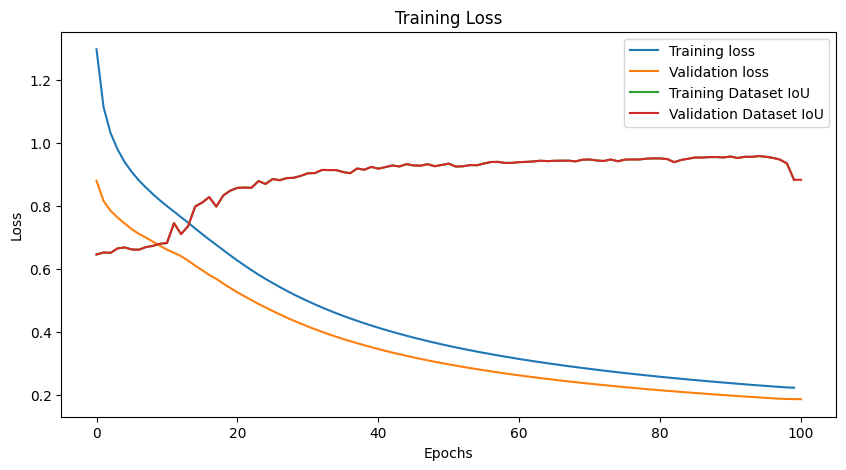

In [24]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"/content/drive/MyDrive/VisionChallenge/version_20/metrics.csv")

# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

display(df_epochs)

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
ax.plot(df_epochs['train_loss'], label="Training loss")
ax.plot(df_epochs['valid_loss'], label="Validation loss")

ax.plot(df_epochs['train_dataset_iou'], label="Training Dataset IoU")
ax.plot(df_epochs['valid_dataset_iou'], label="Validation Dataset IoU")

# Plot the training loss over epochs
# Plot the validation loss over epochs
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

In [ ]:
batch = next(iter(test_dataloader))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

# Load classdict to create a colormap and label mapping
classdict = pd.read_csv(classdict_path)
color_map = {row['name']: [row['r'], row['g'], row['b']] for _, row in classdict.iterrows()}
class_to_index = {class_name: index for index, class_name in enumerate(color_map.keys())}
index_to_class = {index: class_name for class_name, index in class_to_index.items()}

# Create a colormap for matplotlib
rgb_colors = np.array([color_map[class_name] for class_name in sorted(class_to_index, key=class_to_index.get)]) / 255.0
cmap = ListedColormap(rgb_colors)

# Add a legend
def add_color_legend(color_map):
    patches = [
        mpatches.Patch(color=np.array(color) / 255.0, label=class_name)
        for class_name, color in color_map.items()
    ]
    plt.legend(handles=patches, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)

with torch.no_grad():
    model.eval()
    logits = model(batch[0])
pr_masks = logits.sigmoid()

for i, (image, gt_mask, pr_mask) in enumerate(zip(batch[0], batch[1], pr_masks)):
    plt.figure(figsize=(16, 6))

    # Image
    plt.subplot(1, 4, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    # Ground Truth
    gt_array = gt_mask.numpy().squeeze()
    plt.subplot(1, 4, 2)
    plt.imshow(gt_array, interpolation='none')
    plt.title("Ground Truth")
    plt.axis("off")

    # Prediction
    class_labels = pr_mask.argmax(dim=0).cpu().numpy()
    plt.subplot(1, 4, 3)
    plt.imshow(class_labels, interpolation='none')
    plt.title("Prediction")
    plt.axis("off")

    # add_color_legend(color_map)

    # Comparison (Highlight mismatches)
    comparison = (gt_array != class_labels).astype(float)  # 1 for mismatch, 0 for match
    plt.subplot(1, 4, 4)
    plt.imshow(comparison, interpolation='none')  # Red for mismatches
    plt.title("Comparison (Mismatch Highlight)")
    plt.axis("off")

    # Print unique values for ground truth and predictions
    unique_gt = np.unique(gt_array)
    unique_pred = np.unique(class_labels)
    gt_class_names = [index_to_class[idx] for idx in unique_gt]
    pred_class_names = [index_to_class[idx] for idx in unique_pred]
    print(f"Image {i+1} - Ground Truth Classes: {unique_gt}")
    print(f"Image {i+1} - Ground Truth Class Names: {gt_class_names}")
    print(f"Image {i+1} - Predicted Classes: {unique_pred}")
    print(f"Image {i+1} - Predicted Class Names: {pred_class_names}")

    plt.tight_layout()
    plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

# Load classdict to create a colormap and label mapping
classdict = pd.read_csv(classdict_path)
color_map = {row['name']: [row['r'], row['g'], row['b']] for _, row in classdict.iterrows()}
class_to_index = {class_name: index for index, class_name in enumerate(color_map.keys())}
index_to_class = {index: class_name for class_name, index in class_to_index.items()}

# Create a colormap for matplotlib with direct index alignment
num_classes = len(class_to_index)
rgb_colors = np.zeros((num_classes, 3))  # Initialize an array for all classes
for class_name, index in class_to_index.items():
    rgb_colors[index] = np.array(color_map[class_name]) / 255.0  # Assign colors by index
cmap = ListedColormap(rgb_colors)

# Add a legend with consistent indexing
def add_color_legend(class_to_index, color_map):
    patches = [
        mpatches.Patch(color=np.array(color_map[class_name]) / 255.0, label=class_name)
        for class_name, idx in sorted(class_to_index.items(), key=lambda x: x[1])  # Sort by index
    ]
    plt.legend(handles=patches, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)

# Neural network prediction loop
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
pr_masks = logits.sigmoid()

for i, (image, gt_mask, pr_mask) in enumerate(zip(batch[0], batch[1], pr_masks)):
    plt.figure(figsize=(16, 6))

    # Image
    plt.subplot(1, 4, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    # Ground Truth
    gt_array = gt_mask.numpy().squeeze()
    plt.subplot(1, 4, 2)
    plt.imshow(gt_array, cmap=cmap, interpolation='none')  # Use consistent colormap
    plt.title("Ground Truth")
    plt.axis("off")

    # Prediction
    class_labels = pr_mask.argmax(dim=0).cpu().numpy()
    plt.subplot(1, 4, 3)
    plt.imshow(class_labels, cmap=cmap, interpolation='none')  # Use consistent colormap
    plt.title("Prediction")
    plt.axis("off")

    # Comparison (Highlight mismatches)
    comparison = (gt_array != class_labels).astype(float)  # 1 for mismatch, 0 for match
    plt.subplot(1, 4, 4)
    plt.imshow(comparison, cmap="coolwarm", interpolation='none')  # Red for mismatches
    plt.title("Comparison (Mismatch Highlight)")
    plt.axis("off")

    # Print unique values for ground truth and predictions
    unique_gt = np.unique(gt_array)
    unique_pred = np.unique(class_labels)
    gt_class_names = [index_to_class[idx] for idx in unique_gt]
    pred_class_names = [index_to_class[idx] for idx in unique_pred]
    print(f"Image {i+1} - Ground Truth Classes: {unique_gt}")
    print(f"Image {i+1} - Ground Truth Class Names: {gt_class_names}")
    print(f"Image {i+1} - Predicted Classes: {unique_pred}")
    print(f"Image {i+1} - Predicted Class Names: {pred_class_names}")

    # Add a legend to the figure
    add_color_legend(class_to_index, color_map)

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.